# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
%matplotlib inline

In [2]:
import import_ipynb
os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL
from StimulusnResponse import expSnR
from SpatialTemporal_Correlation_and_Convolution import ST_STA

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb
importing Jupyter notebook from StimulusnResponse.ipynb
importing Jupyter notebook from SpatialTemporal_Correlation_and_Convolution.ipynb


In [3]:
def gainasthreshold(x, dt, tau_y, beta):
    t = np.arange(dt,int(tau_y/dt*8))*dt
    Ky = t/tau_y*np.exp(-t/tau_y)/tau_y
    x_n = x.copy()/max(x)
#     plt.plot(x_n)
#     plt.plot(np.convolve(x_n,Ky,'same')*dt)
    y = np.zeros_like(x)
    for i in range(len(x)):
        if i >= len(Ky)-1:
            knyi = np.convolve(y[i-len(Ky)+1:i+1],Ky,'valid')*dt
        else:
            knyi = 0
            for jj in range(i+1):
                knyi += y[jj]*Ky[i-jj]*dt
        gain = 1+beta*knyi
        if gain>1:
            y[i]=x_n[i]
        else:
            y[i]=x_n[i]*gain
    return(y)

# Main

Loading Exp.mat for position series

In [4]:
Fc_list = [2,4,7,10]
filenames = ['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff='+str(Fc)+'_sort_unit2' for Fc in Fc_list]
dt = 0.01
x_list, T_list, rstate_list = expSnR(filenames, dt, 'LED', [21])
for i in range(len(x_list)):
    rstate_list[i] = rstate_list[i][21-1,:]

Calculate velocity

In [5]:
v_list = []
for i in range(len(x_list)):
    v = ndimage.gaussian_filter1d(x_list[i].copy(), sigma=5, order=1, mode='reflect') / dt
    v_list.append(v.copy())    
    x_list[i] = x_list[i]-min(x_list[i])
    rstate_list[i] = rstate_list[i]

Calculate correlation time

In [6]:
t_cor_list = []
for i in range(len(x_list)):
    x_cor = np.correlate(x_list[i], x_list[i], "same")
    x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
    Taxis = np.flip(T_list[i][:len(x_cor)]-dt/2)
    t_cor_list.append( round(np.interp(0.5*max(x_cor),  x_cor, Taxis), 3))

In [7]:
t_cor_list

[135.184, 136.756, 137.722, 138.023]

In [8]:
#assign states
ystate_list = []
xstate_list = []
vstate_list = []

for i in range(len(x_list)):
    xstate, _= EqualState(x_list[i], 6)
    vstate, _= EqualState(v_list[i], 6)
    xstate_list.append(xstate)
    vstate_list.append(vstate)

# Fake Spike - 0D

Negative group delay - 0D

In [9]:
#following paremeters match x+v*0.5s
alpha = 40. #1/sec
beta =  2
K = 40.
g = 2.
phi = 5.
gramma = 100.
p = 100.
psyz = 0.2
psyy = 1-psyz

y_list = []
z_list = []
w_list = []
for i in range(len(x_list)):
    x = x_list[i].copy()
    v = v_list[i].copy()
    y=np.zeros(len(T_list[i]))
    z=np.zeros(len(T_list[i]))
    w=np.zeros(len(T_list[i]))
    x = x-min(x)
    for j in range(len(T_list[i])-1):
        dy = dt*(-alpha*y[j]+K*(x[j]-phi*z[j]))
        dz = dt*(-beta*z[j]+g*y[j])
        dw = dt*(-gramma*w[j]+p*(psyy*y[j]-psyz*z[j]))
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
        w[j+1]=w[j]+dw
    y_list.append(y.copy())
    z_list.append(z.copy())
    w_list.append(w.copy())

Assign states

In [10]:
yFakeSpike_list = [0]*len(x_list)
ystate_list = [0]*len(x_list)
zFakeSpike_list = [0]*len(x_list)
zstate_list = [0]*len(x_list)
wFakeSpike_list = [0]*len(x_list)
wstate_list = [0]*len(x_list)
order = np.arange(len(x_list))
# np.random.shuffle(order)
print(order)
ratioy, thetay, ratioz, thetaz, ratiow, thetaw = 0, 0, 0, 0, 0, 0
for i in order:
    y = y_list[i].copy()
    thetay = 0.*np.std(y) if thetay == 0 else thetay
    r = NL(y-np.mean(y), thetay)
    ratioy = 12/sum(r)*T_list[i][-1] if ratioy == 0 else ratioy
    yFakeSpike_list[i] = Spike_Time_Generater(r*ratioy, dt, 10)
#     print(len(yFakeSpike_list[i])/sum(rstate_list[i]), len(yFakeSpike_list[i])/len(r))
    ystate_list[i], _ = np.histogram(yFakeSpike_list[i], np.append(0,T_list[i]))

    z = z_list[i].copy()
    thetaz = 0.9*np.std(z) if thetaz == 0 else thetaz
    r = NL(-z+np.mean(z), thetaz)
    ratioz = 12/sum(r)*T_list[i][-1] if ratioz == 0 else ratioz
    zFakeSpike_list[i] = Spike_Time_Generater(r*ratioz, dt, 10)
#     print(len(zFakeSpike_list[i])/sum(rstate_list[i]), len(zFakeSpike_list[i])/len(r))
    zstate_list[i], _ = np.histogram(zFakeSpike_list[i], np.append(0,T_list[i]))
    
    w = y_list[i].copy()
    thetaw = 0.*np.std(w) if thetaw == 0 else thetaw
    r = NL(w-np.mean(w), thetaw)
    ratiow = 12/sum(r)*T_list[i][-1] if ratiow == 0 else ratiow
    wFakeSpike_list[i] = Spike_Time_Generater(r*ratiow, dt, 10)
#     print(len(zFakeSpike_list[i])/sum(rstate_list[i]), len(zFakeSpike_list[i])/len(r))
    wstate_list[i], _ = np.histogram(wFakeSpike_list[i], np.append(0,T_list[i]))
    yFakeSpike_list[i] = Spike_Time_Generater(r*ratiow, dt, 10)
    ystate_list[i], _ = np.histogram(yFakeSpike_list[i], np.append(0,T_list[i]))

[0 1 2 3]


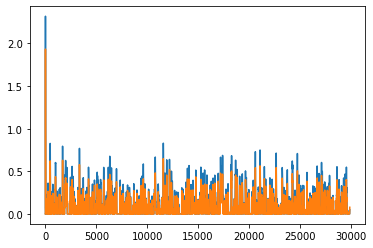

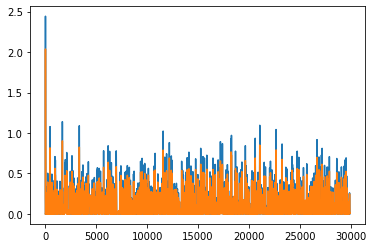

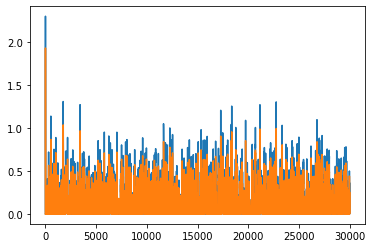

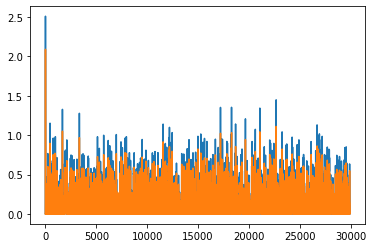

In [11]:
for i in order:
    y = y_list[i].copy()
    r = NL(y-np.mean(y), 0.5*thetay)#+thetay+np.mean(y)
    w = w_list[i].copy()
    rr = NL(w-np.mean(w), thetaw)#+thetaw+np.mean(w)
    plt.plot(r)
    plt.plot(rr)
    plt.show()

In [12]:
# yFakeSpike_list = [0]*len(x_list)
# ystate_list = [0]*len(x_list)
# zFakeSpike_list = [0]*len(x_list)
# zstate_list = [0]*len(x_list)
# wFakeSpike_list = [0]*len(x_list)
# wstate_list = [0]*len(x_list)
# order = np.arange(len(x_list))
# # np.random.shuffle(order)
# print(order)
# ratioy, thetay, ratioz, thetaz, ratiow, thetaw = 0, 0, 0, 0, 0, 0
# for i in order:
#     y = y_list[i].copy()
#     r = gainasthreshold(np.mean(y)-y, dt, 0.02, -10)
#     r = r-min(r)
#     ratioy = 6/sum(r)*T_list[i][-1] if ratioy == 0 else ratioy
#     yFakeSpike_list[i] = Spike_Time_Generater(r*ratioy, dt, 10)
# #     print(len(yFakeSpike_list[i])/sum(rstate_list[i]), len(yFakeSpike_list[i])/len(r))
#     ystate_list[i], _ = np.histogram(yFakeSpike_list[i], np.append(0,T_list[i]))

#     z = z_list[i].copy()
#     r = gainasthreshold(z, dt, 0.02, -10)
#     r = r-min(r)
#     ratioz = 6/sum(r)*T_list[i][-1] if ratioz == 0 else ratioz
#     zFakeSpike_list[i] = Spike_Time_Generater(r*ratioz, dt, 10)
# #     print(len(zFakeSpike_list[i])/sum(rstate_list[i]), len(zFakeSpike_list[i])/len(r))
#     zstate_list[i], _ = np.histogram(zFakeSpike_list[i], np.append(0,T_list[i]))
    
#     w = w_list[i].copy()
#     r = gainasthreshold(w, dt, 0.02, -10)
#     r = r-min(r)
#     ratiow = 6/sum(r)*T_list[i][-1] if ratiow == 0 else ratiow
#     wFakeSpike_list[i] = Spike_Time_Generater(r*ratiow, dt, 10)
# #     print(len(zFakeSpike_list[i])/sum(rstate_list[i]), len(zFakeSpike_list[i])/len(r))
#     wstate_list[i], _ = np.histogram(wFakeSpike_list[i], np.append(0,T_list[i]))

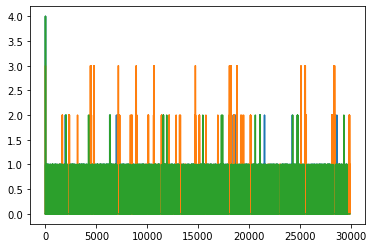

In [13]:
plt.plot(ystate_list[0])
plt.plot(zstate_list[0])
plt.plot(wstate_list[0])

In [23]:
window = [-1,1] # second

## Auto MI

In [35]:
window = [-1,1] # second
AutoMI_list = []
for i in range(len(y_list)):
    AutoMI = {}
    timeshift, Information = PIfunc(xstate_list[i], xstate_list[i], zstate_list[i], dt, window)
    AutoMI['x'] = Information[('Beer','UIx')]+Information[('Beer','Red')]
    _, Information = PIfunc(ystate_list[i], ystate_list[i], zstate_list[i], dt, window)
    AutoMI['y'] = Information[('Beer','UIx')]+Information[('Beer','Red')]
    _, Information = PIfunc(zstate_list[i], zstate_list[i], zstate_list[i], dt, window)
    AutoMI['z'] = Information[('Beer','UIx')]+Information[('Beer','Red')]
    _, Information = PIfunc(wstate_list[i], wstate_list[i], zstate_list[i], dt, window)
    AutoMI['w'] = Information[('Beer','UIx')]+Information[('Beer','Red')]
    AutoMI_list.append(AutoMI.copy())

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anac

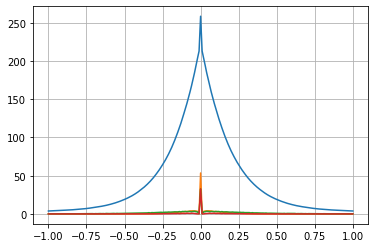

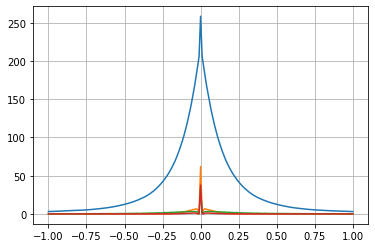

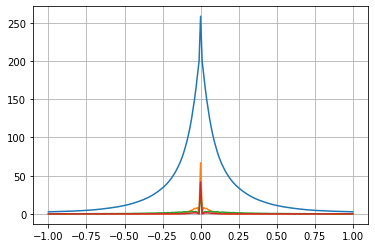

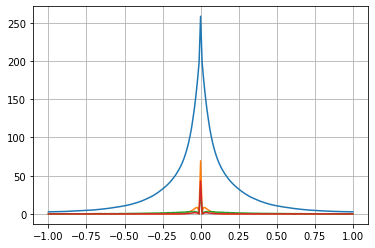

In [36]:
for i in range(len(x_list)):
    fig, ax = plt.subplots()
    ax.plot(timeshift,AutoMI_list[i]['x'])
    ax.plot(timeshift,AutoMI_list[i]['y'])
    ax.plot(timeshift,AutoMI_list[i]['z'])
    ax.plot(timeshift,AutoMI_list[i]['w'])
#     ax.legend( (r'$AutoMI_y$', r'$AutoMI_z$', r'$AutoMI_w$'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax.grid()

## y and z

In [56]:
Information_list = [0]*len(y_list)
for i in range(len(y_list)):
    timeshift, Information_list[i] = PIfunc(xstate_list[i], ystate_list[i], zstate_list[i], dt, window)
    timeshift = np.flip(timeshift)

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anac

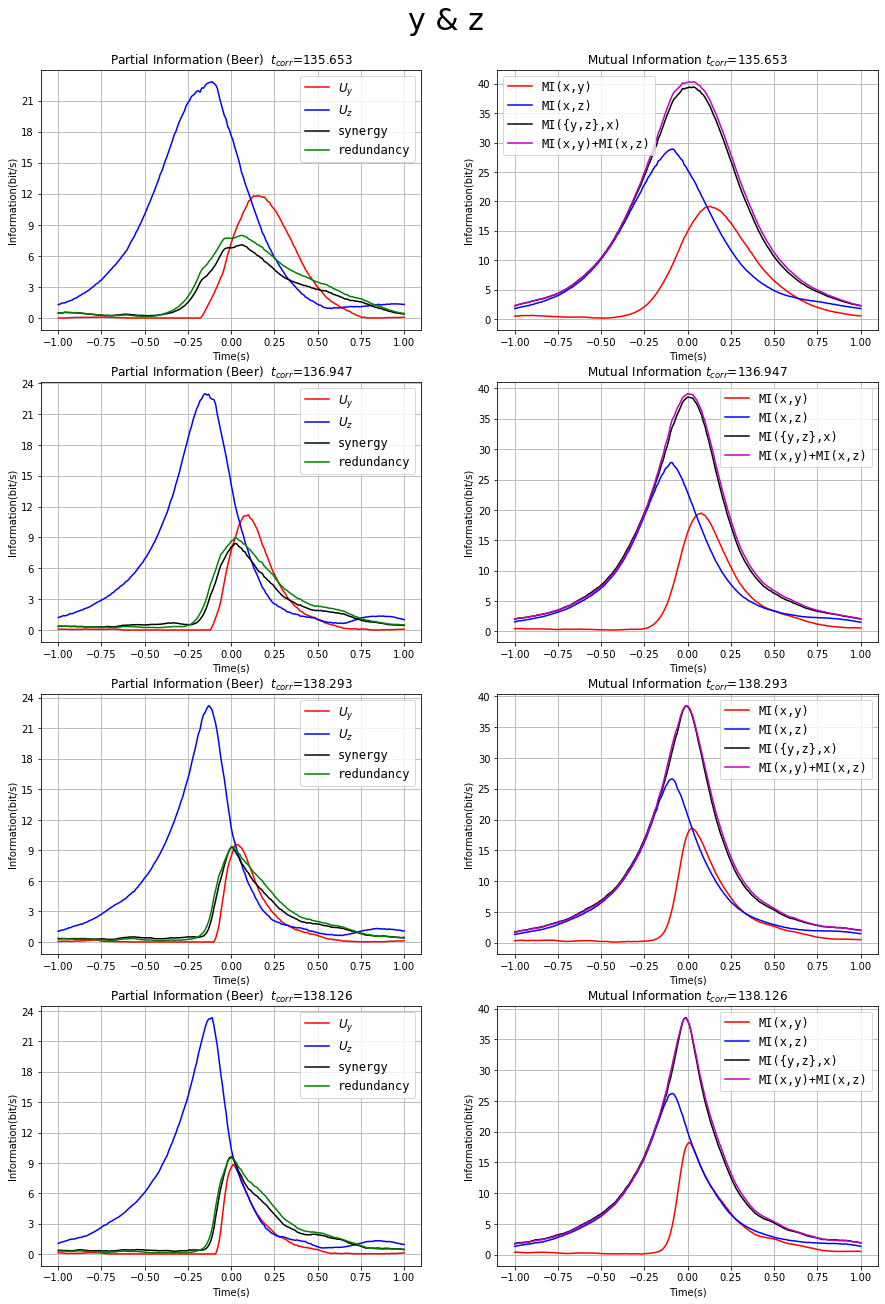

In [57]:
fig, ax = plt.subplots(nrows=len(x_list), ncols=2)
fig.suptitle('y & z', y=0.92, fontsize = 30)
for i in range(len(x_list)):
    ax[i][0].plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax[i][0].plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax[i][0].plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax[i][0].plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax[i][0].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i][0].set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax[i][0].set_xlabel('Time(s)')
    ax[i][0].set_ylabel('Information(bit/s)')
    ax[i][0].legend( (r'$U_y$', r'$U_z$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax[i][0].grid()
    
    #plot MIs
    ax[i][1].plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax[i][1].plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax[i][1].plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax[i][1].plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax[i][1].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i][1].set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax[i][1].set_xlabel('Time(s)')
    ax[i][1].set_ylabel('Information(bit/s)')
    ax[i][1].grid()
    ax[i][1].legend( ('MI(x,y)', 'MI(x,z)', 'MI({y,z},x)', 'MI(x,y)+MI(x,z)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
fig.set_size_inches(15, 5.5*len(x_list))

## y and w

In [29]:
Information_list = [0]*len(y_list)
for i in range(len(y_list)):
    timeshift, Information_list[i] = PIfunc(vstate_list[i], ystate_list[i], wstate_list[i], dt, window)
    timeshift = np.flip(timeshift)

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered

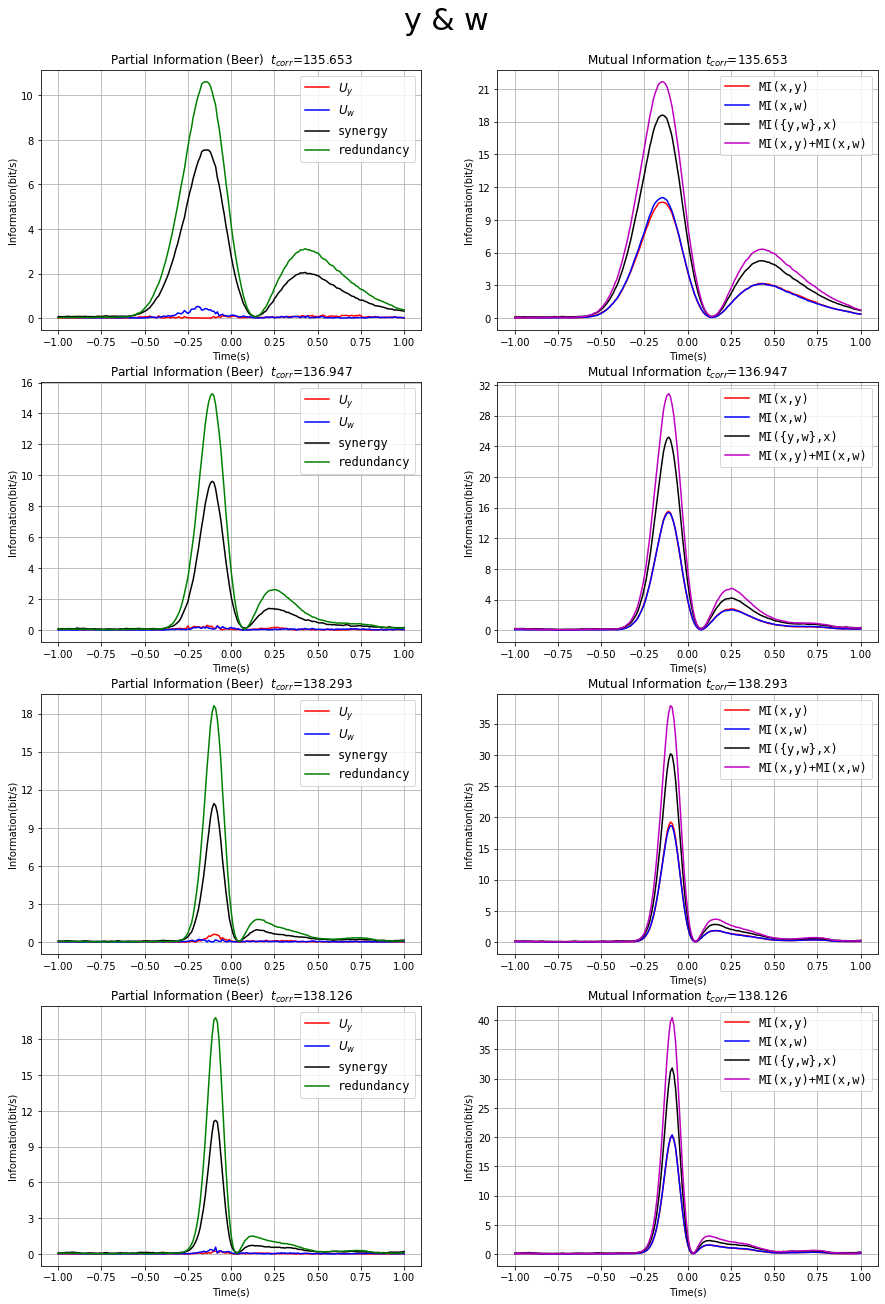

In [30]:
fig, ax = plt.subplots(nrows=len(x_list), ncols=2)
fig.suptitle('y & w', y=0.92, fontsize = 30)
for i in range(len(x_list)): 
    ax[i][0].plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax[i][0].plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax[i][0].plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax[i][0].plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax[i][0].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i][0].set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax[i][0].set_xlabel('Time(s)')
    ax[i][0].set_ylabel('Information(bit/s)')
    ax[i][0].legend( (r'$U_y$', r'$U_w$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax[i][0].grid()
    
    #plot MIs
    ax[i][1].plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax[i][1].plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax[i][1].plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax[i][1].plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax[i][1].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i][1].set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax[i][1].set_xlabel('Time(s)')
    ax[i][1].set_ylabel('Information(bit/s)')
    ax[i][1].grid()
    ax[i][1].legend( ('MI(x,y)', 'MI(x,w)', 'MI({y,w},x)', 'MI(x,y)+MI(x,w)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
fig.set_size_inches(15, 5.5*len(x_list))

## z and w

In [51]:
Information_list = [0]*len(y_list)
for i in range(len(y_list)):
    timeshift, Information_list[i] = PIfunc(xstate_list[i], zstate_list[i], wstate_list[i], dt, window)
    timeshift = np.flip(timeshift)

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anac

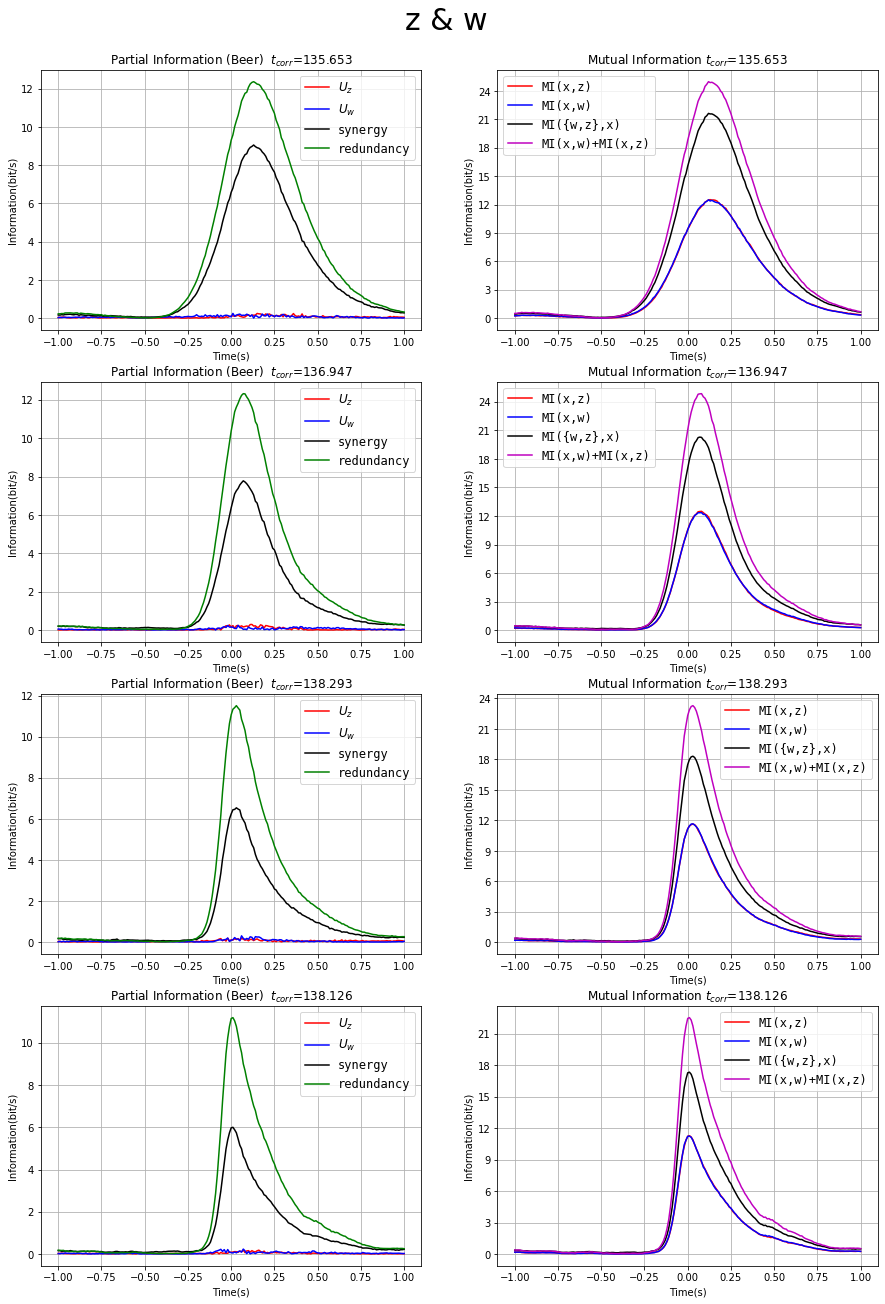

In [52]:
fig, ax = plt.subplots(nrows=len(x_list), ncols=2)
fig.suptitle('z & w', y=0.92, fontsize = 30)
for i in range(len(x_list)):
    ax[i][0].plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax[i][0].plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax[i][0].plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax[i][0].plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax[i][0].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i][0].set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax[i][0].set_xlabel('Time(s)')
    ax[i][0].set_ylabel('Information(bit/s)')
    ax[i][0].legend( (r'$U_z$', r'$U_w$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax[i][0].grid()
    
    #plot MIs
    ax[i][1].plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax[i][1].plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax[i][1].plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax[i][1].plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax[i][1].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i][1].set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax[i][1].set_xlabel('Time(s)')
    ax[i][1].set_ylabel('Information(bit/s)')
    ax[i][1].grid()
    ax[i][1].legend( ('MI(x,z)', 'MI(x,w)', 'MI({w,z},x)', 'MI(x,w)+MI(x,z)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
fig.set_size_inches(15, 5.5*len(x_list))